<a href="https://colab.research.google.com/github/adityasahu88/DL_PROJECTS/blob/main/FOOD_DATASET_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,confusion_matrix
from tqdm.auto import tqdm
import os
import shutil
from sklearn.metrics import confusion_matrix,classification_report
import json

In [ ]:
!kaggle datasets download harishkumardatalab/food-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset
License(s): CC0-1.0
 99%|██████████████████████████████████████▋| 1.67G/1.68G [00:06<00:00, 295MB/s]
100%|███████████████████████████████████████| 1.68G/1.68G [00:06<00:00, 287MB/s]


In [ ]:
!unzip -q  food-image-classification-dataset.zip

In [ ]:
# Count the No of directory
try :
    category =len(os.listdir('Food Classification dataset'))
    print(category)
except Exception as e:
    print(f"{e}")


34


In [ ]:
# count the no of images for each caategory:
try:
    category=[]
    image_count=[]

    for item in tqdm(os.listdir('Food Classification dataset')):
        category.append(str(item))
        image_count.append(len(os.listdir('Food Classification dataset'+'/'+item)))
    category_image=pd.DataFrame(columns=['category','image_count'])
    category_image['category']= category
    category_image['image_count']= image_count
    print(category_image.head(10))

except Exception as e:
    print(f"{e}")




  0%|          | 0/34 [00:00<?, ?it/s]

        category  image_count
0         dhokla          245
1         burger          331
2     paani_puri          144
3  chole_bhature          376
4       Sandwich         1500
5     fried_rice          350
6          momos          323
7          kulfi          214
8   kaathi_rolls          279
9      pav_bhaji          305


<Axes: xlabel='category'>

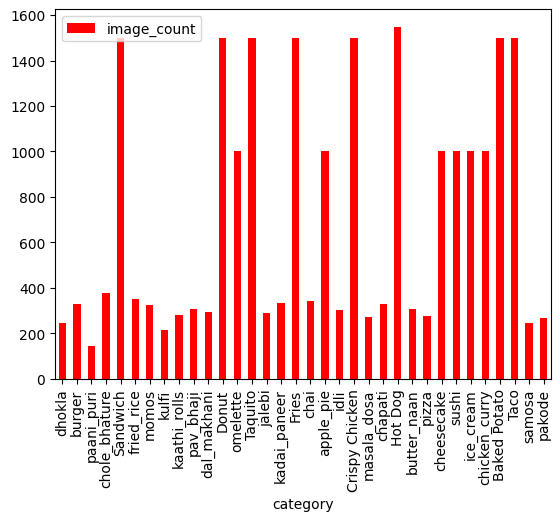

In [ ]:
category_image.plot(kind='bar',x='category',y='image_count',color='red')

- It is observed that there are not equal number of images of each category. So the dataset is imbalanced.
- We will take 200 images of each category so the dataset becomes balanced.

In [ ]:
try :
    if os.path.exists('images'):
        shutil.rmtree('images')
    else:
        os.mkdir('images')
    for item in tqdm(os.listdir('Food Classification dataset'))  :
        if os.path.exists('images/'+item):
            for _item in os.listdir('Food Classification dataset/'+item)[:200]:
                shutil.copy('Food Classification dataset/'+item ,'images/'+item)
        else:
           os.mkdir('images/'+item)
           for _item in os.listdir('Food Classification dataset/'+item)[:200]:
                shutil.copy('Food Classification dataset/'+item+'/'+_item ,'images/'+item)



except Exception as e:
    print(f"{e}")

  0%|          | 0/34 [00:00<?, ?it/s]

- Lets check the image height ,width and channel for each image for each category.

In [ ]:
height_list=[]
width_list=[]
channel_list=[]
item_list=[]
category_list=[]
for category in tqdm(os.listdir('images/')):
    for item in os.listdir('images/'+category):
        image_path ='images/'+category+'/'+item
        img = cv2.imread(image_path)
        height,width,channel =img.shape
        height_list.append(height)
        width_list.append(width)
        channel_list.append(channel)
        item_list.append(item)
        category_list.append(category)

image_df =pd.DataFrame(columns =['category','item','height','width','channel'])
image_df['height']=height_list
image_df['width']=width_list
image_df['channel']=channel_list
image_df['item']=item_list
image_df['category']=category_list
print(image_df.head(10))



  0%|          | 0/34 [00:00<?, ?it/s]

  category              item  height  width  channel
0   dhokla           042.jpg     422    759        3
1   dhokla  download (6).jpg     169    299        3
2   dhokla           088.jpg     700   1024        3
3   dhokla           263.jpg     281    500        3
4   dhokla           139.jpg     532    751        3
5   dhokla           065.jpg     991    720        3
6   dhokla           277.jpg     532    751        3
7   dhokla           087.jpg    1020    680        3
8   dhokla           094.jpg     416    616        3
9   dhokla           025.jpg     720   1280        3


In [ ]:
image_df.describe()

,height,width,channel
count,6744.000000,6744.000000,6744.0
mean,593.032325,685.151097,3.0
std,561.591285,666.883613,0.0
min,94.000000,100.000000,3.0
25%,259.000000,275.000000,3.0
50%,500.000000,512.000000,3.0
75%,700.000000,768.000000,3.0
max,5691.000000,7360.000000,3.0


- For compution easy  we will set the image height and width to 150 * 150
- We will start from Custom model then proceed with VGG16 and ResNet
- As total number of images is 4896 we will **image Data Generator** for easy processing as image data generator uses batch processing for image and get rid of **out of memory**
- For batch processing we will use batch size 32 in which for each batch 32 images will used for image processing so that on less RAM also we can run out model

**Test Image :**
- Extract 50 images from each category for testing purpose.
-We will create a test directory  and place test image
- We will create a label and store the correct correct labels

In [ ]:
#shutil.rmtree('test_images')

In [ ]:
if os.path.exists('test_images'):
    pass
else :
    os.mkdir('test_images')

for category in tqdm(os.listdir('Food Classification dataset')):
    if os.path.exists('test_images/'+category):
       pass
    else :
        os.mkdir('test_images/'+category)
        item_list =np.random.choice(os.listdir('Food Classification dataset/'+category),50,replace=True)
        for sample_item in item_list:
            shutil.copy('Food Classification dataset/'+category+'/'+sample_item,'test_images'+'/'+category+'/')


  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
class dataImagegenerator:
    def __init__(self):
        pass
    def generator(self,batch):
        self.idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                                  validation_split=0.1)
        self.train_idg =self.idg.flow_from_directory('images',
                                                     target_size=(150,150),
                                                     batch_size=batch,
                                                     subset="training")
        self.val_idg =self.idg.flow_from_directory('images',
                                                     target_size=(150,150),
                                                     batch_size=batch,
                                                     subset="validation")
        self.test_idg =self.idg.flow_from_directory('test_images',
                                                     target_size=(150,150),
                                                     batch_size=batch
                                                     )
        print(self.train_idg.class_indices)
try:
    dt =dataImagegenerator()


except Exception as e:
    print(f"{e}")


**Model Creation**

In [ ]:
class CustomModel (dataImagegenerator):
    def __init__(self):
        super().__init__()
        self.batch_list=[32]
        self.epochs_list=[30]
        self.optimizer_dict ={
            "Adam":tf.keras.optimizers.Adam()
        }
        self.best_val_loss =float('inf')
        self.TP=0
        self.FN=0
        self.FP=0
        self.precision=0.00
        self.recall =0.00
        self.f1_score=0.00
    def modelCreation(self):
        model =tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input(shape=(150,150,3),name='InputLayer'))

        # add the CNN layers
        model.add(tf.keras.layers.Conv2D(filters=16,
                                         kernel_size=(3,3),
                                         padding='valid',
                                         strides=(1,1),
                                         name ='Conv1',
                                         activation='relu'
                                          ))

        # add max pooling
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                            padding='valid',
                                            strides=(2,2),
                                            name='MP1'))
        # add the CNN layers
        model.add(tf.keras.layers.Conv2D(filters=32,
                                         kernel_size=(3,3),
                                         padding='valid',
                                         strides=(1,1),
                                         name ='Conv2',
                                         activation='relu'))

        # add max pooling
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                           padding='valid',
                                           strides=(2,2),
                                           name='MP2'))

        # add the CNN layers
        model.add(tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(3,3),
                                         padding='valid',
                                         strides=(1,1),
                                         name ='Conv3',
                                         activation='relu'))

        # add max pooling
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                           padding='valid',
                                          strides=(2,2),
                                           name='MP3'))
        # Add the Flatten layers
        model.add(tf.keras.layers.Flatten(name ='Flatten'))

        # Add the dense layers
        model.add(tf.keras.layers.Dense(512,activation=tf.keras.activations.relu,name='HL1'))
        # Add the dense layers
        model.add(tf.keras.layers.Dense(216,activation=tf.keras.activations.relu,name='HL2'))
        # Add the dense layers
        model.add(tf.keras.layers.Dense(64,activation=tf.keras.activations.relu,name='HL3'))
        # Add the dense layers
        model.add(tf.keras.layers.Dense(32,activation=tf.keras.activations.relu,name='HL4'))
        # add the output layers
        model.add(tf.keras.layers.Dense(34,activation=tf.keras.activations.softmax,name='Outputlayer'))
        return model



    def modelCompile(self,model,optimizer):
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')
                       ])
    def modelFit(self,model,batch,epochs):
        history =model.fit(self.train_idg,
                  validation_data=self.val_idg,
                  epochs=epochs,
                  batch_size=batch)
        return history
    def modelSave(self,model):
        model.save('custom_model.h5')
    def modelEvaluate(self):
        custom_model = tf.keras.models.load_model('custom_model.h5')
        Y_pred = custom_model.predict(self.test_idg)
        y_pred =np.argmax(Y_pred,axis=1)
        y_true = self.test_idg.classes
        # Calculate TP, FP, FN
        self.TP = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
        self.FP = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
        self.FN = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives

        # Compute Precision
        if(self.TP+self.FP)>0:
            self.precision = self.TP / (self.TP + self.FP)
        else :
            self.precision=0.00

        # Compute Recall
        if(self.TP + self.FN)>0:
           self.recall = self.TP / (self.TP + self.FN)
        else :
            self.recall =0

        # Compute F1-score
        if (self.precision+self.recall >0):
            self.f1_score = (2 * self.precision * self.recall) / (self.precision + self.recall)
        else :
            self.f1_score=0

        # Create a dictionary to store metrics
        metrics = {
        "precision": self.precision,
        "recall": self.recall,
        "f1_score": self.f1_score
          }

        # Save metrics to a JSON file
        with open("custom_model_metrics.json", "w") as json_file:
          json.dump(metrics, json_file, indent=4)
          print("Save the metrics")
        cm =confusion_matrix(self.test_idg.classes, y_pred)
        print("Generate the Classification reprot")
        classes = list(self.train_idg.class_indices.keys())
        target_names = classes
        classification_report(self.test_idg.classes, y_pred, target_names=target_names)

    def modelSummary(self,model):
        model.summary()

    def modelRun(self):
        for batch in self.batch_list:
            self.generator(batch)
            for optimizer in self.optimizer_dict.keys():
                for epoch in self.epochs_list:
                    print(f"Training With Optimizer:{optimizer} ,Batch Size : {batch} and epoch : {epoch} ")
                    model = self.modelCreation()
                    self.modelCompile(model,optimizer)
                    history=self.modelFit(model,batch,epoch)
                    val_loss =min(history.history['val_loss'])
                    if val_loss < self.best_val_loss:
                        self.best_val_loss= val_loss
                        self.modelSave(model)


try :
    custom= CustomModel()
    custom.modelRun()
    custom.modelEvaluate()

except Exception as e:
    print(f"{e}")






Found 6070 images belonging to 34 classes.
Found 674 images belonging to 34 classes.
Found 1607 images belonging to 34 classes.
{'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3, 'Hot Dog': 4, 'Sandwich': 5, 'Taco': 6, 'Taquito': 7, 'apple_pie': 8, 'burger': 9, 'butter_naan': 10, 'chai': 11, 'chapati': 12, 'cheesecake': 13, 'chicken_curry': 14, 'chole_bhature': 15, 'dal_makhani': 16, 'dhokla': 17, 'fried_rice': 18, 'ice_cream': 19, 'idli': 20, 'jalebi': 21, 'kaathi_rolls': 22, 'kadai_paneer': 23, 'kulfi': 24, 'masala_dosa': 25, 'momos': 26, 'omelette': 27, 'paani_puri': 28, 'pakode': 29, 'pav_bhaji': 30, 'pizza': 31, 'samosa': 32, 'sushi': 33}
Training With Optimizer:Adam ,Batch Size : 32 and epoch : 30 
Epoch 1/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 68s 315ms/step - accuracy: 0.0335 - f1_score: 0.0170 - loss: 3.5039 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0653 - val_f1_score: 0.0158 - val_loss: 3.2932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
E

**VGG16** is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the popular algorithms for image classification and is easy to use with **transfer learning**.

**Architecture of VGG16**

- 16 layers (13 convolutional + 3 fully connected).
- Uses 3×3 convolutional filters with stride = 1.
- Uses 2×2 max pooling with stride = 2.
- Ends with three fully connected layers and a softmax layer for classification.
- Requires 224×224 RGB images as input.
- VGG16 is computationally expensive, as it has 138 million parameters.

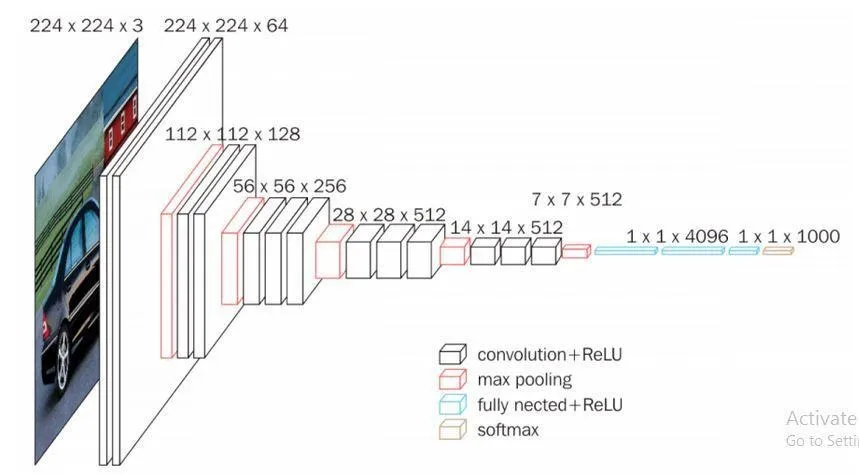

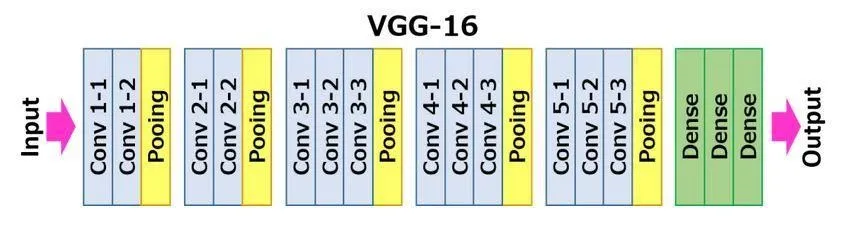

- The 16 in VGG16 refers to 16 layers that have weights.
- In VGG16 there are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.
- VGG16 takes input tensor size as 224, 244 with 3 RGB channel
- Conv-1 Layer has 64 number of filters, Conv-2 has 128 filters, Conv-3 has 256 filters, Conv 4 and Conv 5 has 512 filters.

- Most unique thing about VGG16 is that instead of having a large number of hyper-parameters they focused on having convolution layers of 3x3 filter with stride 1 and always used the same padding and maxpool layer of 2x2 filter of stride 2.

**Transfer Learning**
- Transfer learning is a machine learning technique where a pre-trained model is used as a starting point for a new task. Instead of training a model from scratch, we reuse the knowledge gained from a large dataset and fine-tune it for our specific problem.
- A model trained on ImageNet (1.4 million images) for object recognition can be used to classify medical X-ray images with minimal additional training.
- when we pass our images first the error calculation will very high and we will freeze the convolution layers means no weights and bais values will be updated. Only the fully connected layers  weight and bias values will be updated.

- We freeze the convolutional base (base_model.trainable = False), meaning the weights and biases in the convolutional layers will not be updated during training.
- Only the fully connected (FC) layers (which we added) will be trained and updated using backpropagation.
- Initially, since the FC layers are randomly initialized, the error (loss) will be high at the start of training.
- Over epochs, the FC layers learn to map the extracted features to the correct class.

**VGG16 implementation**

In [ ]:
class VggDataImagegenerator:
    def __init__(self):
        pass
    def generator(self,batch):
        self.idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                                                  validation_split=0.1)
        self.train_idg =self.idg.flow_from_directory('images',
                                                     target_size=(150,150),
                                                     batch_size=batch,
                                                     subset="training")
        self.val_idg =self.idg.flow_from_directory('images',
                                                     target_size=(150,150),
                                                     batch_size=batch,
                                                     subset="validation")
        self.test_idg =self.idg.flow_from_directory('test_images',
                                                     target_size=(150,150),
                                                     batch_size=batch
                                                     )
        print(self.train_idg.class_indices)
try:
    dt =VggDataImagegenerator()


except Exception as e:
    print(f"{e}")


In [ ]:
# load the base model
class VGG16Model (VggDataImagegenerator):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float("inf")
        self.TP=0
        self.FN=0
        self.FP=0
        self.precision=0.00
        self.recall =0.00
        self.f1_score=0.00
    def VGGLoad(self):
        input_layer =tf.keras.layers.Input(shape=(150,150,3))
        base_model= tf.keras.applications.VGG16(include_top=False,
                                                input_tensor=input_layer)
        base_model.trainable=False
        base_model.summary()
        return base_model

    def ModelCreation(self,base_model):
        flatten =tf.keras.layers.Flatten() (base_model.output)
        H1= tf.keras.layers.Dense(512,activation=tf.keras.activations.relu)(flatten)
        H2= tf.keras.layers.Dense(128,activation=tf.keras.activations.relu)(H1)
        H3= tf.keras.layers.Dense(64,activation=tf.keras.activations.relu)(H2)
        H4= tf.keras.layers.Dense(32,activation=tf.keras.activations.relu)(H3)
        output = tf.keras.layers.Dense(34,activation=tf.keras.activations.softmax)(H4)
        final_model = tf.keras.models.Model(inputs=[base_model.input],outputs =[output])
        return final_model


    def modelCompile(self,model):
         model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')
                       ])

    def modelFit(self,model,batch,epochs):

        history =model.fit(self.train_idg,
                  validation_data=self.val_idg,
                  epochs=epochs,
                  batch_size=batch)
        return history

    def modelSave(self,model):
        model.save('VGG16Model.h5')
    def modelEvaluate(self):
        vgg_model = tf.keras.models.load_model('VGG16Model.h5')
        Y_pred = vgg_model.predict(self.test_idg)
        y_pred =np.argmax(Y_pred,axis=1)
        y_true = self.test_idg.classes
        # Calculate TP, FP, FN
        self.TP = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
        self.FP = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
        self.FN = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives

        # Compute Precision
        if(self.TP+self.FP)>0:
            self.precision = self.TP / (self.TP + self.FP)
        else :
            self.precision=0.00

        # Compute Recall
        if(self.TP + self.FN)>0:
           self.recall = self.TP / (self.TP + self.FN)
        else :
            self.recall =0

        # Compute F1-score
        if (self.precision+self.recall >0):
            self.f1_score = (2 * self.precision * self.recall) / (self.precision + self.recall)
        else :
            self.f1_score=0

        # Create a dictionary to store metrics
        metrics = {
        "precision": self.precision,
        "recall": self.recall,
        "f1_score": self.f1_score
          }

        # Save metrics to a JSON file
        with open("vgg16_model_metrics.json", "w") as json_file:
          json.dump(metrics, json_file, indent=4)






        cm =confusion_matrix(self.test_idg.classes, y_pred)
        print("Generate the Classification reprot")
        classes = list(self.train_idg.class_indices.keys())
        target_names = classes
        classification_report(self.test_idg.classes, y_pred, target_names=target_names)



    def modelRun(self):
        self.generator(32)
        vgg_base_model=self.VGGLoad()
        model = self.ModelCreation(vgg_base_model)
        self.modelCompile(model)
        history=self.modelFit(model,32,30)
        val_loss =min(history.history['val_loss'])
        if val_loss < self.best_val_loss:
            self.best_val_loss= val_loss
            self.modelSave(model)


try :
    objVGG16Model=VGG16Model()
    objVGG16Model.modelRun()
    objVGG16Model.modelEvaluate()

except Exception as e:
    print(f"{e}")


Found 6070 images belonging to 34 classes.
Found 674 images belonging to 34 classes.
Found 1607 images belonging to 34 classes.
{'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3, 'Hot Dog': 4, 'Sandwich': 5, 'Taco': 6, 'Taquito': 7, 'apple_pie': 8, 'burger': 9, 'butter_naan': 10, 'chai': 11, 'chapati': 12, 'cheesecake': 13, 'chicken_curry': 14, 'chole_bhature': 15, 'dal_makhani': 16, 'dhokla': 17, 'fried_rice': 18, 'ice_cream': 19, 'idli': 20, 'jalebi': 21, 'kaathi_rolls': 22, 'kadai_paneer': 23, 'kulfi': 24, 'masala_dosa': 25, 'momos': 26, 'omelette': 27, 'paani_puri': 28, 'pakode': 29, 'pav_bhaji': 30, 'pizza': 31, 'samosa': 32, 'sushi': 33}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 82s 355ms/step - accuracy: 0.0519 - f1_score: 0.0354 - loss: 4.7799 - precision: 0.2006 - recall: 0.0141 - val_accuracy: 0.0950 - val_f1_score: 0.0617 - val_loss: 3.2910 - val_precision: 0.8684 - val_recall: 0.0490
Epoch 2/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.1307 - f1_score: 0.0914 - loss: 3.1844 - precision: 0.7562 - recall: 0.0574 - val_accuracy: 0.1840 - val_f1_score: 0.1146 - val_loss: 2.9688 - val_precision: 0.6429 - val_recall: 0.1068
Epoch 3/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 52s 259ms/step - accuracy: 0.2328 - f1_score: 0.1723 - loss: 2.7686 - precision: 0.6681 - recall: 0.1287 - val_accuracy: 0.2967 - val_f1_score: 0.2307 - val_loss: 2.6068 - val_precision: 0.8103 - val_recall: 0.1395
Epoch 4/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 51s 256ms/step - accuracy: 0.3378 - f1_score: 0.2875 - loss: 2.3561 - precision: 0.7685 - recall: 0.2103 - val_accuracy: 0.3412 - val_f1_score: 0.2980 - val_loss: 2.2872 - val_precision: 0.7442 -

- **ResNet50** is a powerful image classification model that can be trained on large datasets
- The architecture of ResNet50 is divided into four main parts:
     - the convolutional layers,
     - the identity block,
     -  the convolutional block, and
     -  the fully connected layers.
- The convolutional layers are responsible for extracting features from the input image, while the identity block and convolutional block are responsible for processing and transforming these features. Finally, the fully connected layers are used to make the final classification.

**Convolutional Layers**
- The convolutional layers in ResNet50 consist of several convolutional layers followed by batch normalization and ReLU activation.
- These layers are responsible for extracting features from the input image, such as edges, textures, and shapes.
- The convolutional layers are followed by max pooling layers, which reduce the spatial dimensions of the feature maps while preserving the most important features.

**Identity block and Convolutional block**
- The identity block and convolutional block are the key building blocks of ResNet50.
- The identity block is a simple block that passes the input through a series of convolutional layers and adds the input back to the output.
-  This allows the network to learn residual functions that map the input to the desired output.
-   The convolutional block is similar to the identity block, but with the addition of a 1x1 convolutional layer that is used to reduce the number of filters before the 3x3 convolutional layer.

**Fully Connected Layers**
- The final part of ResNet50 is the fully connected layers.
- These layers are responsible for making the final classification.
- The output of the final fully connected layer is fed into a softmax activation function to produce the final class probabilities.

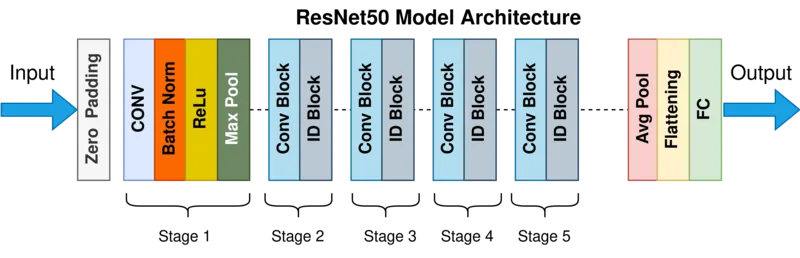

In [ ]:
class RestNet50Model(VggDataImagegenerator):
    def __init__(self):
        super().__init__()
        self.TP=0
        self.FN=0
        self.FP=0
        self.precision=0.00
        self.recall =0.00
        self.f1_score=0.00
    def LoadModel(self):
        input_layer =tf.keras.layers.Input(shape=(150,150,3))
        base_model =  tf.keras.applications.ResNet50(include_top=False,
                                                     input_tensor=input_layer)
        base_model.trainable=False
        base_model.summary()
        return base_model
    def CreateModel(self,base_model):
        flatten = tf.keras.layers.Flatten() (base_model.output)
        h1 = tf.keras.layers.Dense(512,activation='relu') (flatten)
        h2 = tf.keras.layers.Dense(256,activation='relu') (h1)
        output = tf.keras.layers.Dense(34,activation='sigmoid') (h2)
        model = tf.keras.Model(inputs=[base_model.input],outputs=[output])
        return model
    def CompileModel(self,model):
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.F1Score(name='f1_score')
                      ])
    def FitModel(self,epochs,batch,model):
        model.fit(self.train_idg,validation_data=self.val_idg,
                  epochs=epochs,batch_size=batch)
    def SaveModel(self,model):
        model.save('Resnet50.h5')
    def EvaluateModel(self):
        resnet_model = tf.keras.models.load_model('Resnet50.h5')
        Y_pred = resnet_model.predict(self.test_idg)
        y_pred =np.argmax(Y_pred,axis=1)
        y_true = self.test_idg.classes
        # Calculate TP, FP, FN
        self.TP = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
        self.FP = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
        self.FN = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives

        # Compute Precision
        if(self.TP+self.FP)>0:
            self.precision = self.TP / (self.TP + self.FP)
        else :
            self.precision=0.00

        # Compute Recall
        if(self.TP + self.FN)>0:
           self.recall = self.TP / (self.TP + self.FN)
        else :
            self.recall =0

        # Compute F1-score
        if (self.precision+self.recall >0):
            self.f1_score = (2 * self.precision * self.recall) / (self.precision + self.recall)
        else :
            self.f1_score=0

        # Create a dictionary to store metrics
        metrics = {
        "precision": self.precision,
        "recall": self.recall,
        "f1_score": self.f1_score
          }

        # Save metrics to a JSON file
        with open("resnet50_model_metrics.json", "w") as json_file:
          json.dump(metrics, json_file, indent=4)
        cm =confusion_matrix(self.test_idg.classes, y_pred)
        print("Generate the Classification reprot")
        classes = list(self.train_idg.class_indices.keys())
        target_names = classes
        classification_report(self.test_idg.classes, y_pred, target_names=target_names)


    def ModelRun(self):
        self.generator(32)
        base_model =self.LoadModel()
        resent_model =self.CreateModel(base_model)
        self.CompileModel(resent_model)
        self.FitModel(30,32,resent_model)
        self.SaveModel(resent_model)



try :
    resnet50 = RestNet50Model()
    resnet50.ModelRun()
    resnet50.EvaluateModel()

except Exception as e:
    print(f"{e}")


Found 6070 images belonging to 34 classes.
Found 674 images belonging to 34 classes.
Found 1607 images belonging to 34 classes.
{'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3, 'Hot Dog': 4, 'Sandwich': 5, 'Taco': 6, 'Taquito': 7, 'apple_pie': 8, 'burger': 9, 'butter_naan': 10, 'chai': 11, 'chapati': 12, 'cheesecake': 13, 'chicken_curry': 14, 'chole_bhature': 15, 'dal_makhani': 16, 'dhokla': 17, 'fried_rice': 18, 'ice_cream': 19, 'idli': 20, 'jalebi': 21, 'kaathi_rolls': 22, 'kadai_paneer': 23, 'kulfi': 24, 'masala_dosa': 25, 'momos': 26, 'omelette': 27, 'paani_puri': 28, 'pakode': 29, 'pav_bhaji': 30, 'pizza': 31, 'samosa': 32, 'sushi': 33}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 78s 338ms/step - accuracy: 0.2706 - f1_score: 0.2517 - loss: 10.1526 - precision: 0.0442 - recall: 0.7819 - val_accuracy: 0.6291 - val_f1_score: 0.6208 - val_loss: 1.3438 - val_precision: 0.0539 - val_recall: 0.9881
Epoch 2/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.8595 - f1_score: 0.8531 - loss: 0.4801 - precision: 0.0553 - recall: 0.9994 - val_accuracy: 0.6632 - val_f1_score: 0.6643 - val_loss: 1.3351 - val_precision: 0.0525 - val_recall: 0.9911
Epoch 3/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.9508 - f1_score: 0.9453 - loss: 0.1151 - precision: 0.0539 - recall: 1.0000 - val_accuracy: 0.6988 - val_f1_score: 0.6998 - val_loss: 1.3405 - val_precision: 0.0543 - val_recall: 0.9911
Epoch 4/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 52s 268ms/step - accuracy: 0.9688 - f1_score: 0.9593 - loss: 0.0399 - precision: 0.0558 - recall: 1.0000 - val_accuracy: 0.6973 - val_f1_score: 0.7091 - val_loss: 1.2836 - val_precision: 0.0552 